# Flowers Classfication

We a simple example to demonstrate how to use tensorflow datasets and tf2.3

@date: 01-Aug-2020 | @author: katnoria

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import Model

In [ ]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [ ]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [6]:
# Load the dataset
ds, info = tfds.load('tf_flowers', split='train', shuffle_files=True, with_info=True)

In [7]:
len(ds)

3670

Use the built in function to visualise the dataset 

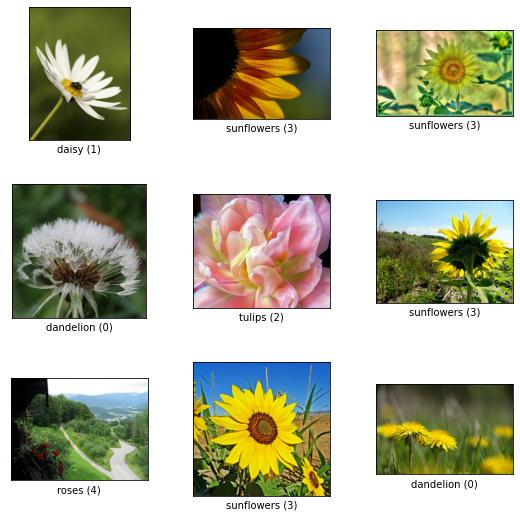

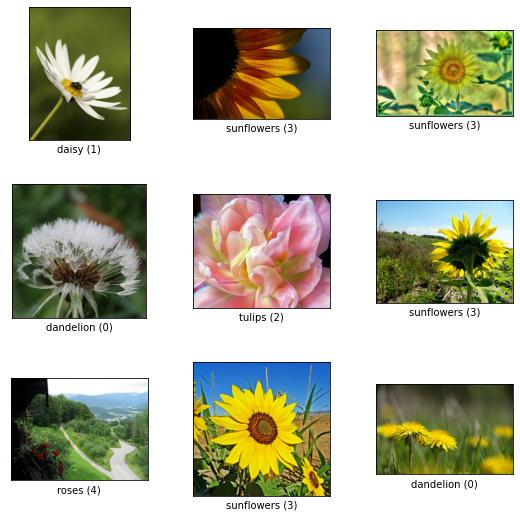

In [8]:
# Use the built-in 
tfds.show_examples(ds, info)

In [9]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

In [10]:
print(f"Number of classes: {info.features['label'].num_classes}")
print(f"Labels: {info.features['label'].names}")
print(f"Int label to Str: {info.features['label'].int2str(3)}")
print(f"Str label to Int: {info.features['label'].str2int('sunflowers')}")

Number of classes: 5
Labels: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Int label to Str: sunflowers
Str label to Int: 3


In [11]:
print(info.features['image'].shape)
print(info.features['image'].dtype)

(None, None, 3)
<dtype: 'uint8'>


In [12]:
print(info.splits)

{'train': <tfds.core.SplitInfo num_examples=3670>}


In [13]:
for example in ds.take(1):
    print(list(example.keys()))
    image = example['image']
    label = example['label']
    print(image.shape, label)

['image', 'label']
(212, 320, 3) tf.Tensor(3, shape=(), dtype=int64)


## Create Train and Test Splits

We now load the train and test splits and build the training pipeline. Flowers dataset does not provide train and test split so we will need to do it ourselves. And, that too is rather straightforward with the datasets library 🎉.

In [14]:
(ds_train, ds_test), metadata = tfds.load(
    'tf_flowers',
    split=[
        'train[:80%]',
        'train[-20%:]',        
    ],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 2936
Test dataset size: 734


In [15]:
# (ds_train, ds_test), metadata = tfds.load(
#     "stanford_dogs",
#     split=["train", "test"],
#     shuffle_files=True,
#     with_info=True,
#     as_supervised=True,
# )
 
# NUM_CLASSES = metadata.features["label"].num_classes

In [16]:
# set as_supervised = False
# tfds.show_examples(ds_test, metadata)

### Training Pipeline

In [17]:
IMG_SIZE = 128
BATCH_SIZE = 16


def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image / 255., label

In [18]:
train_ds = ds_train.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [19]:
example = train_ds.take(1)

### Evaluation Pipeline

In [20]:
test_ds = ds_test.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

# Build Model

We now build a simple convolution neural network

In [21]:
class FlowersModel(Model):
    def __init__(self):
        super(FlowersModel, self).__init__()
        self.conv1 = Conv2D(128, 3, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(256, 3, padding='same')
        self.bn2 = BatchNormalization()        
        self.flatten = Flatten()
        self.dense1 = Dense(512, activation='relu')
#         self.gap = GlobalAveragePooling2D()
        self.dense2 = Dense(NUM_CLASSES)
        
    def call(self, x, training=False):
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = tf.nn.relu(x)
#         x = self.gap(x)
        x = self.flatten(x)
        x = self.dense1(x)
        if training:
            x = tf.nn.dropout(x, rate=0.2)
        out = self.dense2(x)
        return out

In [63]:
model = FlowersModel()
first_batch = tf.zeros((1, 64, 64, 3))
model(first_batch)
model.summary()

Model: "flowers_model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           multiple                  3584      
_________________________________________________________________
batch_normalization_16 (Batc multiple                  512       
_________________________________________________________________
conv2d_17 (Conv2D)           multiple                  295168    
_________________________________________________________________
batch_normalization_17 (Batc multiple                  1024      
_________________________________________________________________
flatten_8 (Flatten)          multiple                  0         
_________________________________________________________________
dense_16 (Dense)             multiple                  536871424 
_________________________________________________________________
dense_17 (Dense)             multiple              

In [64]:
model = FlowersModel()

Create the loss function and optimizer

In [23]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

We are going to measure the train and test accuracy of the model

In [24]:
# Train
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_acc')

# Test
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_acc')

We now train the model

In [51]:
# Training step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    # collect the gradients and apply
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    # loss & acc
    train_loss(loss)
    train_acc(labels, predictions)
    
    
# Test step    
@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_fn(labels, predictions)
    # loss & acc
    test_loss(loss)
    test_acc(labels, predictions)

# Train the model

Now, its time to train the model for N epochs

In [ ]:
num_epochs = 100
print_every = .1

for epoch in range(num_epochs):
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()
    
    for images, labels in train_ds:
        train_step(images, labels)
        
    for tst_images, tst_labels in test_ds:
        test_step(tst_images, tst_labels)
        
    if epoch % print_every == 0:
        print(f"Epoch {epoch+1}: loss={train_loss.result():.4f}, accuracy: {train_acc.result():.4f} :: test loss={test_loss.result():.4f}, test accuracy: {test_acc.result():.4f}")

# Use Keras fit Method

In [25]:
model = FlowersModel()
model.compile(
    loss=loss_fn, 
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],    
)
model.fit(
    train_ds,
    epochs=6,
    validation_data=test_ds,
)

Epoch 1/6


ResourceExhaustedError: in user code:

    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    <ipython-input-21-9714e567099f>:22 call  *
        x = self.dense1(x)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:982 __call__  **
        self._maybe_build(inputs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2643 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:1178 build
        trainable=True)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:614 add_weight
        caching_device=caching_device)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/training/tracking/base.py:750 _add_variable_with_custom_getter
        **kwargs_for_getter)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:145 make_variable
        shape=variable_shape if variable_shape else None)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:221 _variable_v1_call
        shape=shape)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:685 variable_capturing_scope
        lifted_initializer_graph=lifted_initializer_graph, **kwds)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:264 __call__
        return super(VariableMetaclass, cls).__call__(*args, **kwargs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:226 __init__
        initial_value() if init_from_fn else initial_value,
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/keras/initializers/initializers_v2.py:397 __call__
        return super(VarianceScaling, self).__call__(shape, dtype=_get_dtype(dtype))
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops_v2.py:561 __call__
        return self._random_generator.random_uniform(shape, -limit, limit, dtype)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops_v2.py:1044 random_uniform
        shape=shape, minval=minval, maxval=maxval, dtype=dtype, seed=self.seed)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/random_ops.py:302 random_uniform
        shape, dtype, seed=seed1, seed2=seed2)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/ops/gen_random_ops.py:726 random_uniform
        _ops.raise_from_not_ok_status(e, name)
    /home/ashish/miniconda3/envs/tf2_3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:6843 raise_from_not_ok_status
        six.raise_from(core._status_to_exception(e.code, message), None)
    <string>:3 raise_from
        

    ResourceExhaustedError: OOM when allocating tensor with shape[4194304,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]
